In [92]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

In [93]:
def prep_questions(qpath="data/questions-words.txt"):

    dquestions = {}
    with open(qpath, 'r') as fd:
        key = None
        tests = fd.read().lower().split('\n')
        rest = tests.pop()
        for test in tests:
            categ = test[0]
            if categ == ':':
                dquestions[test] = []
                key = test
            else:
                dquestions[key].append(test.split(' '))
    return dquestions

dqts = prep_questions()

# Reconstruindo os resultados

In [94]:
dscores = {}
for flog in os.listdir("outputs/models/"):
    with open(f"outputs/models/{flog}", 'r') as fd:
        dscores[flog.replace(".json",'')] = json.load(fd)

In [95]:
def get_params(key):
    
    tokens = key.split('_')
    wsize = int(tokens[1].split('-')[-1])
    vsize = int(tokens[3].split('-')[-1])
    sg = int(tokens[4].split('-')[-1])
    mcount = int(tokens[-1].split('-')[-1])

    return wsize, vsize, sg, mcount

rows = []
# Para cada modelo.
for key in dscores:
    wsize, vsize, sg, mcount = get_params(key)
    # para cada categoria no modelo.
    for categ in dscores[key]:
        try:
            hits = dscores[key][categ]["hits"]
            misses = dscores[key][categ]["misses"]
            close_to = dscores[key][categ]["close_to"]
            score = dscores[key][categ]["score"]
            rows.append([categ, vsize, wsize, sg, mcount, hits, misses, close_to, score])
        except:
            print(key)


In [96]:
cols = ['category', 'vector_size', 'window_size', 'sg', 'min_count', 'hits', 'misses', 'close_to', 'score']
df = pd.DataFrame(rows, columns=cols)
df.head()

,category,vector_size,window_size,sg,min_count,hits,misses,close_to,score
0,: capital-common-countries,100,1,1,1,0,506,0,0.000000
1,: capital-world,100,1,1,1,0,4524,0,0.000000
2,: currency,100,1,1,1,0,866,0,0.000000
3,: city-in-state,100,1,1,1,0,2467,0,0.000000
4,: family,100,1,1,1,38,387,81,65.224211


In [97]:
def plot_distib(df, var_target, observed_vars=['hits', 'misses', 'score', 'close_to'], dqts=None):
    

    plt.figure(figsize=(25,5))
    plt.tight_layout()
    cont = 1
    flag_legend = True
    # Para cada variável de interesse.
    for tvar in observed_vars:
        lines = ["-","--","-.",":"]
        linecycler = cycle(lines)
        # Para cada categoria.
        for categ in set(df.category):
            # Filtrando o dataset por categoria.
            categ_df = df[df.category == categ].sort_values(by=[var_target])
            # Pegando os labels do eixo-x.
            x_labels = categ_df[var_target].values
            x = list(range(1, len(x_labels) + 1))
            y = categ_df[tvar].values / len(dqts[categ])
            plt.subplot(1,4, cont)
            plt.yticks(fontsize=14)
            if flag_legend:
                plt.plot(x, y, label=categ, linestyle=next(linecycler))
            else:
                plt.plot(x, y, linestyle=next(linecycler))
            plt.xticks(x, x_labels, fontsize=14)
        # Formatando os gráficos.
        plt.xticks(x, x_labels, fontsize=14, rotation=45)
        plt.xlabel(var_target, fontsize=14)
        yl = f"{tvar} (%)"
        if tvar == "score":
            yl = tvar
        plt.ylabel(yl, fontsize=14)
        plt.grid()
        cont += 1
        flag_legend = False
    plt.figlegend(ncol=3, loc="upper center", fontsize=16, bbox_to_anchor =(0.5, 1.35))#, borderpad=0.3)
    plt.tight_layout()

def plot_distib_average(df, var_target, observed_vars=['hits', 'misses', 'score', 'close_to']):
    
    plt.figure(figsize=(25,4))
    cont = 1
    flag_legend = True
    # Para cada variável de interesse.
    for tvar in observed_vars:
        # Calculando os valores médios.
        plt.subplot(1,4, cont)
        y = df.groupby(var_target).agg({tvar: "mean"}).sort_values(by=[var_target]).values
        y = y.reshape(y.shape[0])
        y_std = df.groupby(var_target).agg({tvar: "std"}).values
        y_std = y_std.reshape(y_std.shape[0])
        x_labels = df[df.category == df.category.iloc[0]].sort_values(by=[var_target])[var_target]
        x = list(range(1, len(x_labels) + 1))
        if flag_legend:
            plt.errorbar(x, y, y_std, label="Average", marker='o')
            flag_legend = False
        else:
            plt.errorbar(x, y, y_std, marker='o')
        # Formatando os gráficos.
        plt.xticks(x, x_labels, fontsize=14, rotation=45)
        plt.xlabel(var_target, fontsize=14)
        yl = f"{tvar} (%)"
        if tvar == "score":
            yl = tvar
        plt.ylabel(yl, fontsize=14)
        plt.grid()
        cont += 1
    plt.figlegend(ncol=4, loc="upper center", fontsize=16)

# Análise do tamanho da janela (window_size)

### Fixando os demais parâmetros para a análise. Dimensão dos vetores 100, Skip-Gram ativado, Frequência mínima das palavras 1.

In [98]:
window_df = df[(df.vector_size == 100) & (df.sg == 1) & (df.min_count == 1)]
window_df.head(5)

,category,vector_size,window_size,sg,min_count,hits,misses,close_to,score
0,: capital-common-countries,100,1,1,1,0,506,0,0.000000
1,: capital-world,100,1,1,1,0,4524,0,0.000000
2,: currency,100,1,1,1,0,866,0,0.000000
3,: city-in-state,100,1,1,1,0,2467,0,0.000000
4,: family,100,1,1,1,38,387,81,65.224211


## Discusão impactos da variação do tamanho da janela (Window Size)

#### Legendas

* Gráfico 1: (eixo X) window_size x (eixo Y) porcentagem de acertos (hits)
* Gráfico 2: (eixo X) window_size x (eixo Y) porcentagem de erros (misses)
* Gráfico 3: (eixo X) window_size x (eixo Y) score normalizado (1/ri * si), para ri a posição da palavra esperada no ranking de palavras mais próximas e si a similaridade entre o vetor resultante e a palavra esperada.
* Gráfico 4: (eixo X) window_size x (eixo Y) quantidade de aparições da palavra esperada no ranking (close_to)

*** Todos os valores nos gráficos abaixo foram normalizados pela quantidade de testes de cada catetoria.

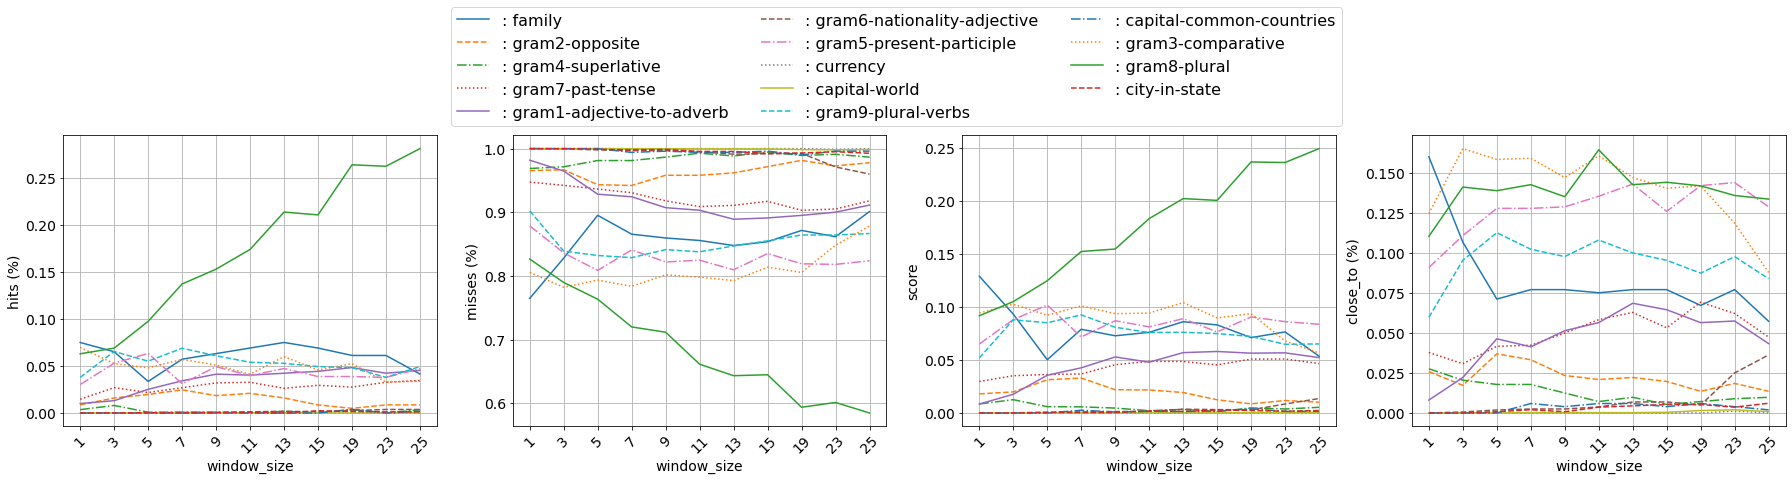

In [99]:
plot_distib(window_df, 'window_size', dqts=dqts)

O tamanho da janela influencia na captura da realção semântica entre palavras. Janelas curtas podem reduzir a quantidade capturada pelos modelos de relação semântica existente entre duas palavras não tão próximas. Porém, evita que relações semanticas erroneas sejam capturadas entre palavras não tão próximas semanticamente. O inverso é verdade para o aumento do tamanho das janelas.

No primeiro gráfico, temos o conjunto de todas o desempenho de todas as categorias variando o tamanho da janela utilizada no treinamento dos modelos. Visivelmente o aumento do tamanho da janela dos modelos não beneficiou o desempenho dos mesmos em nenhuma categoria menos a gramar8-plural. Como podemos ver, para essa categoria a quantidade de hits (vezes em que a palavra mais próxima é a palavra esperada) ficou maior que 25% dos testes para janelas de tamanho 19. Consequentemente a quantidade de misses (vezes que a palavra não apareceu no ranking) caiu de ~78% para ~62% (16 pontos percentuais) e o score (inverso da posição da palavra no ranking pela similaridade de cosseno entre o vetor resultante e a palavra esperada) que aumentou significativamente, saindo de ~9.7 com a janela de tamanho 1, indo para 25% com a janela de tamanho 25. O close_to (gráfico 4) obteve um leve aumento com ápice para janela de tamanho 13, porém decaiu novamente. Essa queda pode ser explicada pelo fato do número de hits ter aumentado, dessa forma, as palavras sairam das suas posíções de close_to (de 2 à 5) no ranking e foram para a primeira posição.

Devemos levar em consideração que, para a categoria gram8-plural aumentar o tamanho da janela é benéfico e provavelmente específico para esta categoria. Desta forma, para tarefas específicas relacionadas ao trabalho com plural, janelas maiores tendem a ter resultados melhores. Por outro lado, categorias como gram5-present-participle, gram6-nationality-adjective não foram influenciadas pela variação do tamanho da janela, de modo que os valores obtidos para tais categorias permaneceram praticamente constantes, com elevado número de misses 92,3% para primeira e ~100% para a segunda, para todo tamanho de janela. Outra categoria que manteve baixos valores de hits constantes para quase todo os valores de janela foi a categoria currency. Como Podemos ver no gráfico 1, 2, ela teve ~0% de hits, ~100% de misses para janelas de tamanho menor que 20. Porém, para janela de tamanho 23 e 25 temos um leve aumento no score (gráfico 3) e no close_to, mostrando que a palavra esperada começa a surgir no ranking. Também podemos ver uma queda de aproximadamente %5 na quantidade de misses (gráfico 2).

Para as demais categorias, os modelos não monstram tendências significativas, somente a categoria gram3-comparative, que ao contrário das categorias a cima, apresenta ligeira queda na quantidade de hits, score e close_to, porém, análises mais específicas sobre essa categoria seriam necessárias para confirmar a tendência na da queda do desempenho conforme o aumento do tamanho da janela.

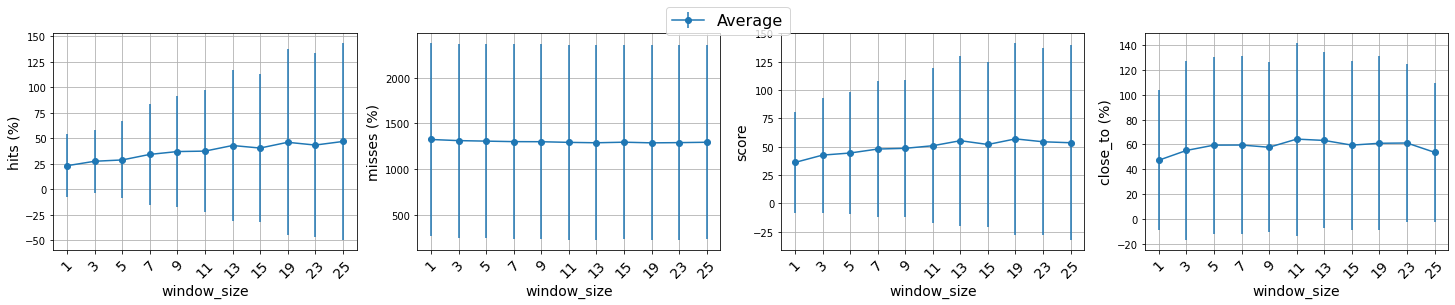

In [100]:
plot_distib_average(window_df, 'window_size')

No geral, não podemos inferir melhorias significativas no aumento ou redução do tamanho da janela, visto que os modelos não monstram uma tendência geral de queda ou subida de desempenho para as categorias em conjunto. No gráfico 1, podemos ver que existe um aumento na quantidade de hits no comportamento médio dos modelos conforme aumentamos o tamanho da janela, porém, a partir do desvio padrão, podemos também notar a instabilidade dos resultados, sendo que para janela de tamanho 25, onde a maior média chega a 49 hits, o desvio padrão aumenta drasticamente, podendo o resultado ser pior que qualquer tamanho de janela inferior. Sugeri-se que este comportamento é fortemente influenciado por categorias como a gram8-plural onde os modelos aumentaram seu desempenho conforme aumentaram o tamanho da janela.

Com os resutaldos apresentados nas análises anteriores, apresentamos fortes indícios de que a variação do tamanho da janela, deve-se levar em consideração a tarefa fim da utilização dos vetores de embeddings, sendo em que a captura de informação pluralística, janelas maiores tendem a apresentar melhores resultados.

# Analisando a dimensão do embedding (vector_size)

### Fixando os demais parâmetros para a análise. Tamanho da janela 5, Skip-Gram ativado, Frequência mínima das palavras 1.

In [101]:
vector_df = df[(df.window_size == 5) & (df.sg == 1) & (df.min_count == 1)]
vector_df.head(5)

,category,vector_size,window_size,sg,min_count,hits,misses,close_to,score
56,: capital-common-countries,200,5,1,1,0,506,0,0.000000
57,: capital-world,200,5,1,1,0,4524,0,0.000000
58,: currency,200,5,1,1,0,866,0,0.000000
59,: city-in-state,200,5,1,1,0,2466,1,0.156486
60,: family,200,5,1,1,33,430,43,38.169100


## Discusão impactos da variação do tamanho da janela (Vector Size)

#### Legendas

* Gráfico 1: (eixo X) vector_size x (eixo Y) porcentagem de acertos (hits)
* Gráfico 2: (eixo X) vector_size x (eixo Y) porcentagem de erros (misses)
* Gráfico 3: (eixo X) vector_size x (eixo Y) score normalizado (1/ri * si), para ri a posição da palavra esperada no ranking de palavras mais próximas e si a similaridade entre o vetor resultante e a palavra esperada.
* Gráfico 4: (eixo X) vector_size x (eixo Y) quantidade de aparições da palavra esperada no ranking (close_to)

*** Todos os valores nos gráficos abaixo foram normalizados pela quantidade de testes de cada catetoria.

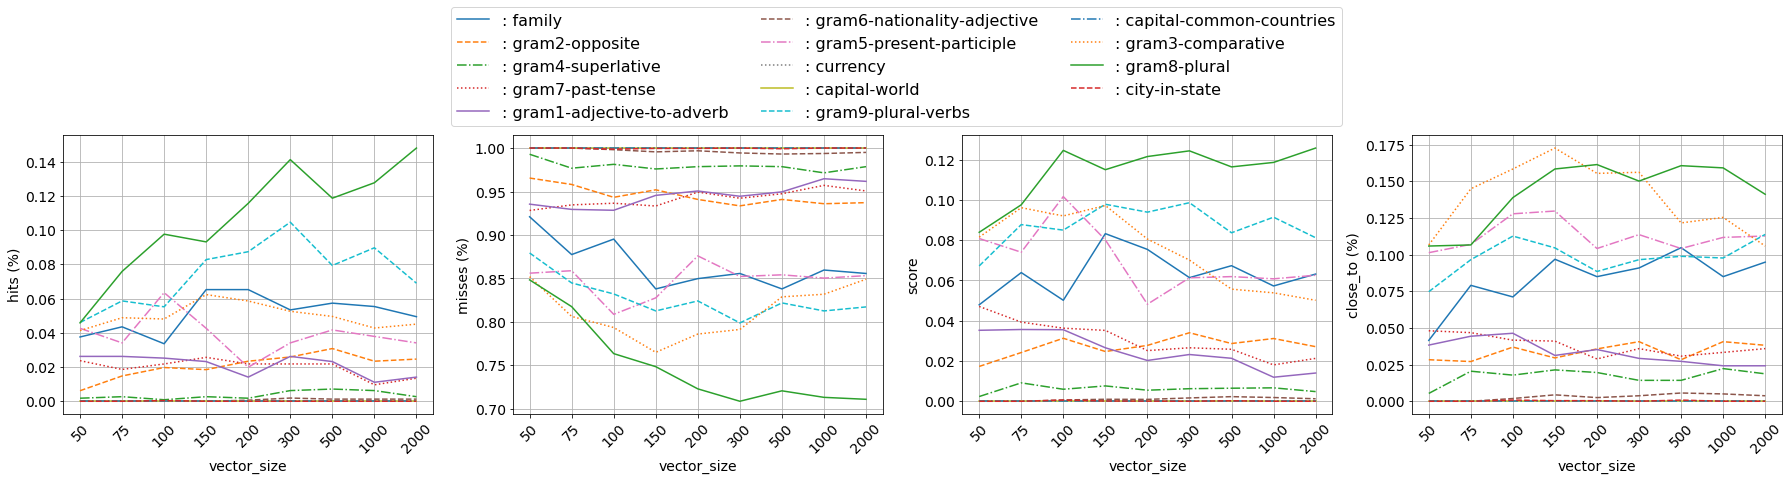

In [102]:
plot_distib(vector_df, 'vector_size', dqts=dqts)

A quantidade de dimensões dos vetores não influencia somente no desempenho dos modelos, mas também fortemente no tempo e recursos gastos para trabalhar com as representações, de modo que, quanto menor e mais distintivo for uma representação vetorial, melhor é esta para tarefas de NLP no geral. Porém, nem sempre é possível inserir toda a informação de um corpos em vetores com poucas dimensões e o vetores de dimensão maior passam a ser mais atrativos, conforme aumenta-se o desempenho dos modelos que usam as representações vetorias.

Observando o primeiro gráfico, duas categorias (gram8-plural, gram9-plural-verbs) apresentam maior variação no aumento da dimensão das representações, sendo a primeira com ápice com dimensão 2000 (d-2000) e a segunda com dimensão 300 (d-300). Para a categoria gram8-plural, apesar das representações d-2000 apresentarem maior desempenho na avaliação intrínseca, o custo computacional pode não valer a pena, uma vez que a diferença é de 6,66 na ordem de grandeza e o custo computacional pode ser bastante impactado. Além disso, para a categoria gram9-plural o ápice é em d-300. Dessa forma, sendo gram8-plural e gram9-plural-verbs, categorias de teste semânticamente bastante correlacionadas, os resultados mostram que d-300 é uma boa escolha de dimensão para trabalhar com pluralidade. 

Como ocorrido na variação do tamanho da janela, as categorias gram6-nationality-adjective, gram5-present-participle e currency permaneceram praticamente constantes, com altos índices de erro conforme variou-se a dimensão das representações. A categoria gram7-past-tense, por outro lado, apresenta leve tendência conforme aumenta-se a dimensão dos vetores, diferente das anteriores que apesar de aumentarem em certo ponto apresentaram fortes quedas ou grandes oscilações. Porém, ainda é necessário análises mais profundas para identifcar e validar porque dimensões mais altas colaboram para a melhora do desempenho dos modelos para esta categoria.

No geral, podemos perceber que, dimensões acima de 300 não beneficiou fortemente nenhuma categoria, sendo a maior parte dos melhores resutaldos contidos no intervalo de 50-300. Desta forma, indicamos que representações maiores (d > 300) não trazem ganhos e podem prejudicar o desempenho dos modelos nas tarefas fim em tempo e acertividade.



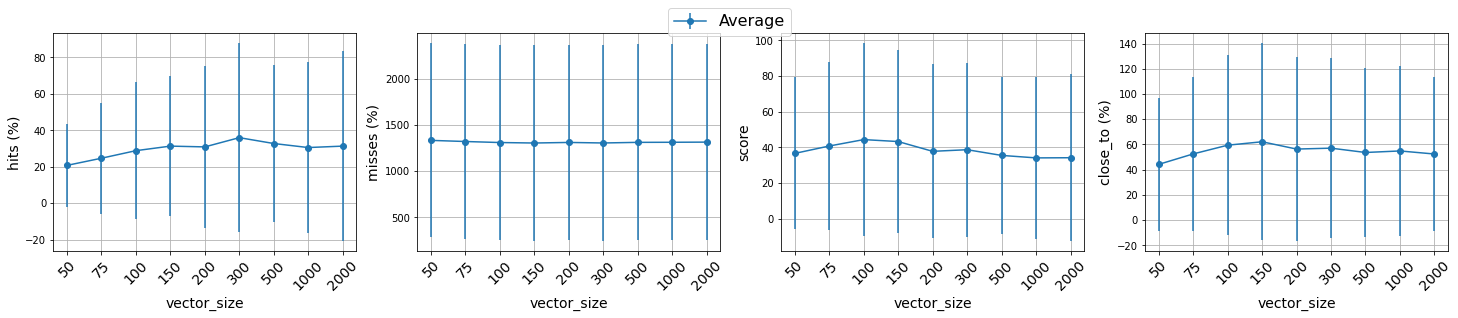

In [103]:
plot_distib_average(vector_df, 'vector_size')

# Comparando os modelos Skip-Gram e CBOW.

In [104]:
skip_cbow = df[(df.window_size == 5) & (df.vector_size == 100) & (df.min_count == 1)]
skip_cbow.head(5)

,category,vector_size,window_size,sg,min_count,hits,misses,close_to,score
28,: capital-common-countries,100,5,0,1,0,506,0,0.000000
29,: capital-world,100,5,0,1,0,4522,2,0.357964
30,: currency,100,5,0,1,0,866,0,0.000000
31,: city-in-state,100,5,0,1,0,2463,4,1.707354
32,: family,100,5,0,1,16,456,34,23.920499


In [105]:
y = skip_cbow[skip_cbow.sg == 1]
y

,category,vector_size,window_size,sg,min_count,hits,misses,close_to,score
210,: capital-common-countries,100,5,1,1,0,506,0,0.000000
211,: capital-world,100,5,1,1,0,4524,0,0.000000
212,: currency,100,5,1,1,0,866,0,0.000000
213,: city-in-state,100,5,1,1,1,2464,2,1.429811
214,: family,100,5,1,1,17,453,36,25.380842
215,: gram1-adjective-to-adverb,100,5,1,1,25,921,46,35.254525
216,: gram2-opposite,100,5,1,1,16,766,30,25.407169
217,: gram3-comparative,100,5,1,1,64,1057,211,122.622815
218,: gram4-superlative,100,5,1,1,1,1101,20,6.689974
219,: gram5-present-participle,100,5,1,1,67,854,135,107.354271


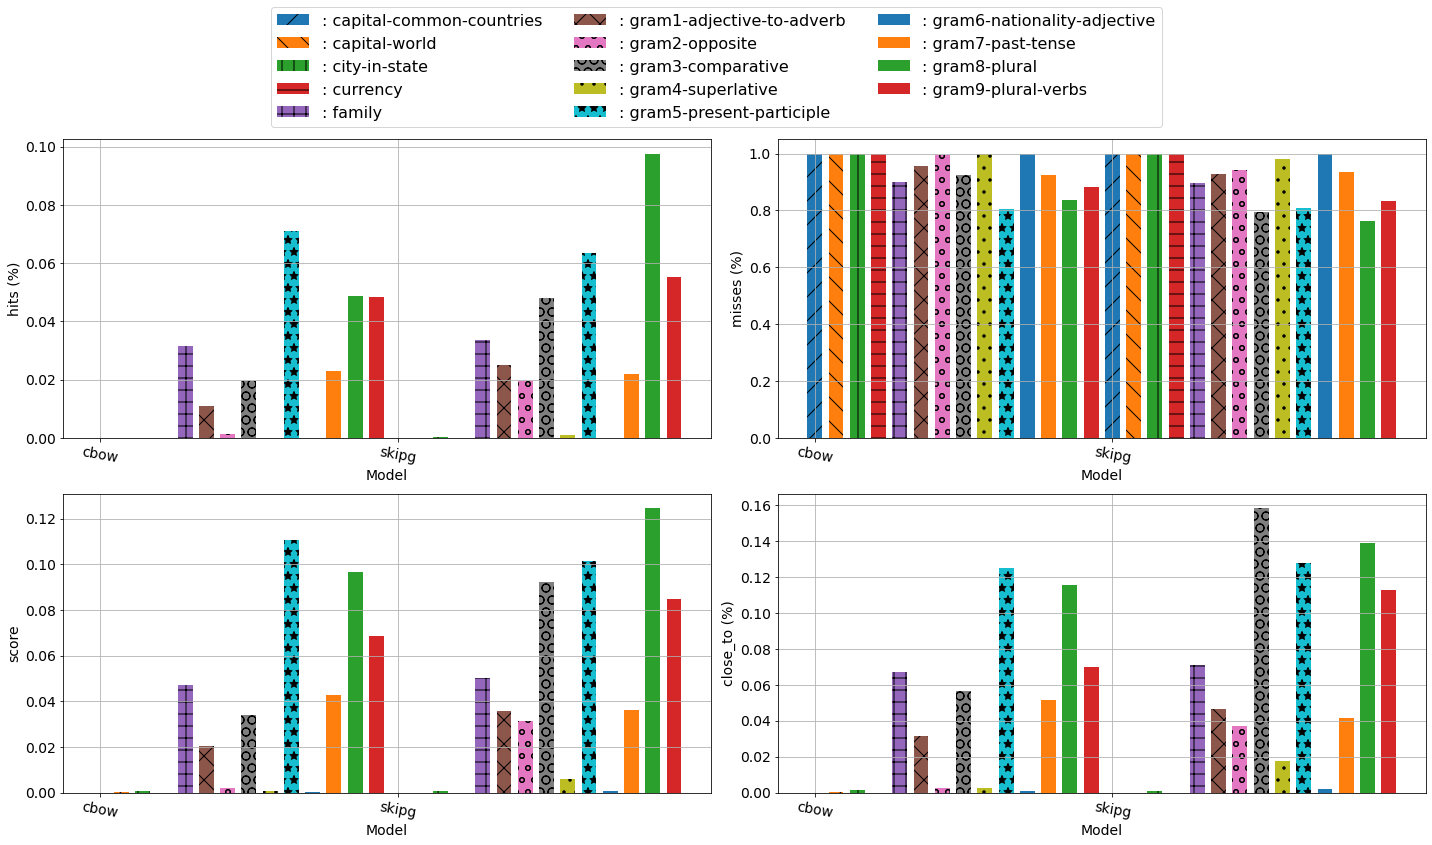

In [167]:
def get_x(begin, gap, len):

    values = []
    acc = begin
    for i in range(len):
        values.append(acc)
        acc += gap
    return np.array(values)

def plot_bar_all_vars(skip_cbow, dqts=None, begin_gap=1):
    
    plt.figure(figsize=(20, 10))
    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    index = 1
    watched_vars = ["hits", "misses", "score", "close_to"]
    flag_legend = True
    for wvar in watched_vars:
        first_categ = True
        begin = 1
        categs = sorted(set(skip_cbow.category))
        gap = len(categs)
        sg_values = [0,1]
        var_len = len(sg_values)
        row = ((index) // 2) + 1
        col = (index % 2) + 1
        plt.subplot(2, 2, index)
        patt_cont = 0
        # Para cada categoria.
        for categ in categs:
            categ_df = skip_cbow[skip_cbow.category == categ]
            # Para cada tipo de modelo.
            y = []
            for sg in sg_values:
                subd = categ_df[categ_df.sg == sg].sort_values(by=["category"])
                y.append(subd[wvar].values[0] / len(dqts[categ]))
            x = get_x(begin, gap, var_len)
            if len(patterns) > patt_cont:
                hat = patterns[patt_cont]
            else:
                hat = None
            if flag_legend:
                bar = plt.bar(x, y, label=categ, hatch=hat, width=0.7)
            else:
                bar = plt.bar(x, y, hatch=hat, width=0.7)
            begin += begin_gap
            if first_categ:
                plt.xticks([1, gap + 1], ["cbow", "skipg"], rotation=-10, fontsize=14)
                plt.yticks(fontsize=14)
                first_categ = False
            patt_cont += 1
        flag_legend = False
        plt.grid()
        label = wvar
        if label != "score":
            label = f"{label} (%)"
        plt.ylabel(f"{label}", fontsize=14)
        plt.xlabel("Model", fontsize=14)
        index += 1
    
    plt.figlegend(ncol=3, loc="upper center", fontsize=16, bbox_to_anchor =(0.5, 1.18))
    plt.tight_layout()
plot_bar_all_vars(skip_cbow, dqts, begin_gap=1)

In [ ]:
def identity(x):
    return x

tabs = []
for col in ["hits", "misses", "score", "close_to"]:
    t = pd.crosstab(skip_cbow.category, skip_cbow.sg, values=skip_cbow[col].values, aggfunc=identity)
    tabs.append(t)

In [ ]:
table = pd.concat(tabs, axis=1)
table

sg,0,1,0,1,0,1,0,1
category,,,,,,,,
: capital-common-countries,0,0,506,506,0.000000,0.000000,0,0
: capital-world,0,0,4522,4524,0.357964,0.000000,2,0
: city-in-state,0,1,2463,2464,1.707354,1.429811,4,2
: currency,0,0,866,866,0.000000,0.000000,0,0
: family,16,17,456,453,23.920499,25.380842,34,36
: gram1-adjective-to-adverb,11,25,950,921,20.230288,35.254525,31,46
: gram2-opposite,1,16,809,766,1.712443,25.407169,2,30
: gram3-comparative,26,64,1231,1057,45.030943,122.622815,75,211
: gram4-superlative,0,1,1119,1101,0.521419,6.689974,3,20


In [ ]:
agg = { m: "mean" for m in ['hits', 'misses', 'score', 'close_to'] }

g = skip_cbow.groupby(by="sg").agg(agg)
g

,hits,misses,score,close_to
sg,,,,
0,19.428571,1335.214286,33.266248,41.357143
1,28.785714,1307.857143,44.409421,59.357143


In [ ]:
gt = g.T
gtr = gt.values.T.reshape(gt.shape[0] * 2)
pd.DataFrame(gtr).T

,0,1,2,3,4,5,6,7
0,19.428571,1335.214286,33.266248,41.357143,28.785714,1307.857143,44.409421,59.357143


# Avaliação da frequência mínima das palavras

In [ ]:
min_count_df = df[(df.window_size == 5) & (df.vector_size == 100) & (df.sg == 1)]
min_count_df.head(5)

,category,vector_size,window_size,sg,min_count,hits,misses,close_to,score
14,: capital-common-countries,100,5,1,5,0,505,1,0.213002
15,: capital-world,100,5,1,5,0,4523,1,0.213002
16,: currency,100,5,1,5,0,866,0,0.000000
17,: city-in-state,100,5,1,5,1,2464,2,1.092888
18,: family,100,5,1,5,21,456,29,25.240842


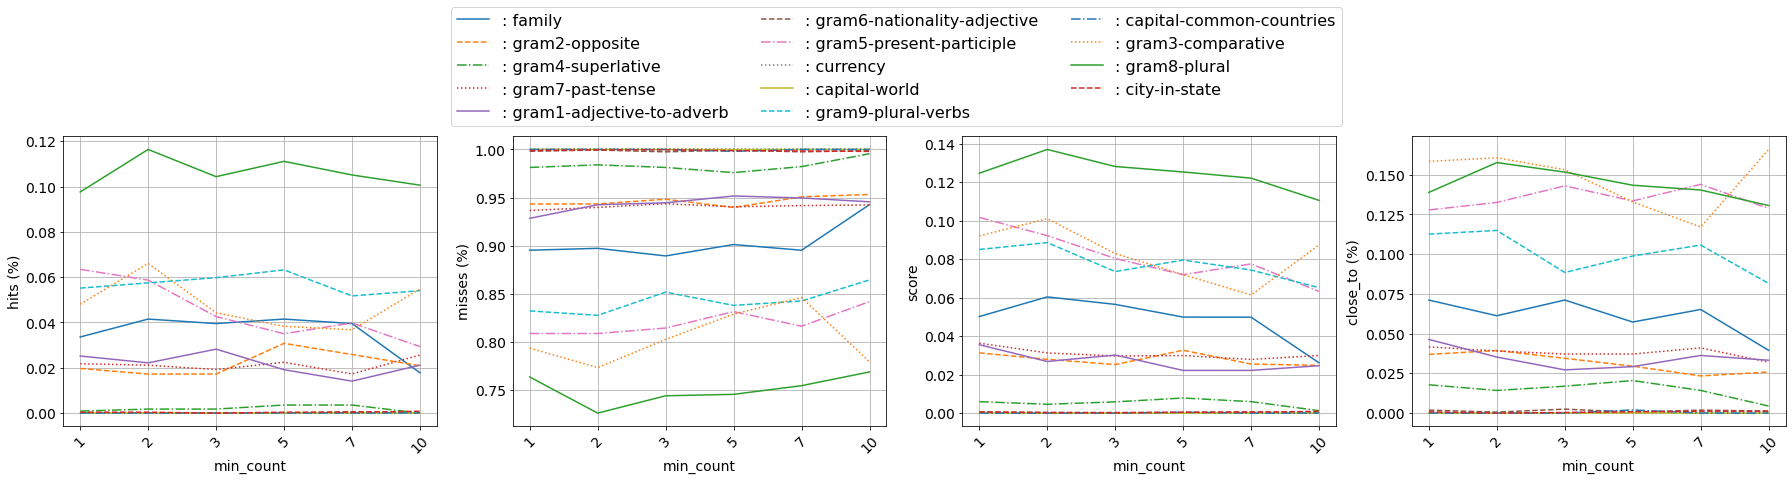

In [ ]:
plot_distib(min_count_df, 'min_count', dqts=dqts)

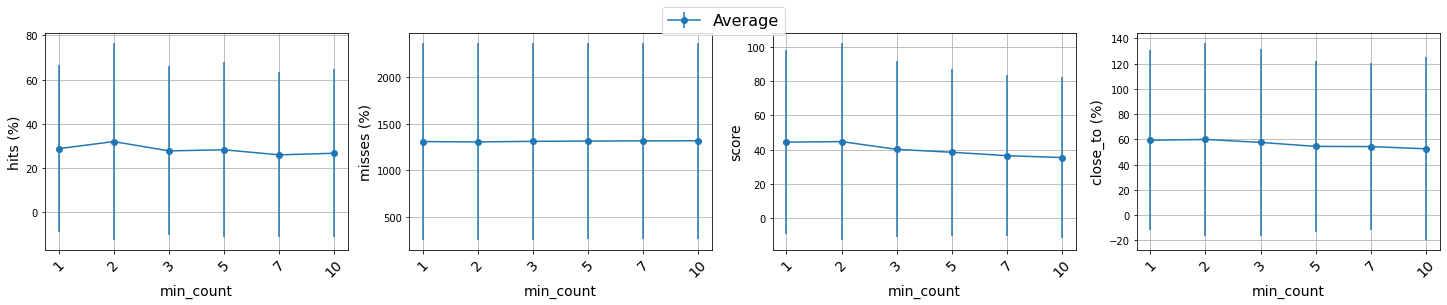

In [ ]:
plot_distib_average(min_count_df, 'min_count')

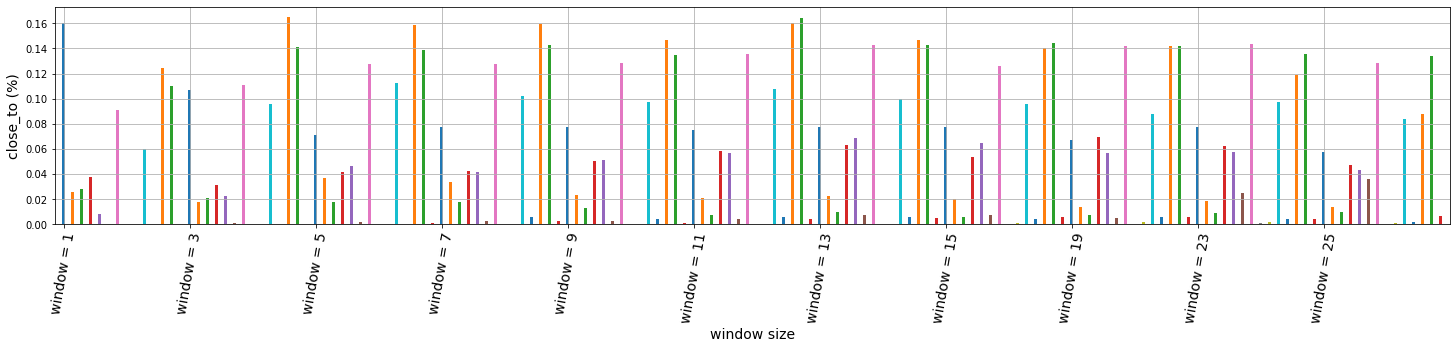

In [ ]:
def get_x(begin, gap, len):

    values = []
    acc = begin
    for i in range(len):
        values.append(acc)
        acc += gap
    return np.array(values)
    
plt.figure(figsize=(25,4))
ax = plt.subplot(111)
begin = 0
categs = set(window_df.category)
gap = len(categs)
graph_len = len(set(window_df.window_size))
# Para cada categoria.
for categ in categs:
    categ_df = window_df[window_df.category == categ ]
    # Para cada tamanho de janela.
    y = []
    wds = sorted(set(categ_df.window_size))
    for wd in wds:
        wd_df = categ_df[categ_df.window_size == wd]
        y.append(wd_df["close_to"].iloc[0])
    y = np.array(y) / len(dqts[categ])
    x = get_x(begin, gap, graph_len)
    ax.bar(x, y, width=0.4, align="center")
    # Se for a primeira categoria.
    if begin == 0:
        wds_labels = [ f"window = {v}" for v in wds ]
        ax.set_xticks(x, labels=wds_labels, rotation=80, fontsize=14)
    begin += 1

ax.set_xlabel("window size", fontsize=14)
ax.set_ylabel(f"close_to (%)", fontsize=14)
ax.set_xlim([-1, gap * graph_len])
ax.grid()